In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

### ResNet with convolutional block

> Resizing logic (note this does skip connections after 2 conv layers because figure is ResNet-50, however for ResNet-34 and ResNet-18 we skip after 1 conv block  

![conv block resnet](./ResidualBlock.png)

image source: https://stackoverflow.com/questions/58200107/stuck-understanding-resnets-identity-block-and-convolutional-blocks

Helpful resources (implementations of residual blocks): https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb 

https://stackoverflow.com/questions/60817390/implementing-a-simple-resnet-block-with-pytorch


![resnet18andresnet34layers](./resnet.png)

In [31]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

# Trying an implementation of ResNet 

class ResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel, block_type='convolution'):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        # For ResNet18 as input and output dimensions will always match.
        self.skip_connection = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(output_channel)
        )
        
        self.block_type = block_type
        
    def forward(self, x):
        if self.block_type is 'convolution':
            shortcut = self.skip_connection(x)
        else:
            shortcut = x
        block = self.block(x)
        x = nn.functional.relu(block + shortcut)
        return x


## Should we try maxpooling after residual blocks?
## ResNet18 Architecture: https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248
## ResNet18 Architecture: https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.initial_cnn_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2)),
        )
        
        self.residual_block_1 = ResidualBlock(64, 64, block_type='identity')
        self.residual_block_2 = ResidualBlock(64, 128)
        
        self.residual_block_3 = ResidualBlock(128, 128, block_type='identity')
        self.residual_block_4 = ResidualBlock(128, 256)
        

        self.residual_block_5 = ResidualBlock(256, 256, block_type='identity')
        self.residual_block_6 = ResidualBlock(256, 512)
        
        
        
        self.residual_block_7 = ResidualBlock(512, 512, block_type='identity')
        
        # shrink final conv layer width to 1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(512*1*1, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            nn.Linear(1024, 8)
        )
    
    def forward(self, x):
        x = self.initial_cnn_layer(x)
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.residual_block_4(x)        
        x = self.residual_block_5(x)
        x = self.residual_block_6(x)        
        x = self.residual_block_7(x)        
        x = self.avgpool(x)
    
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        
        return F.log_softmax(x, dim=1) 
        

In [32]:
net = ResNet18()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.001
# optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 200
epochs = 120


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
ResNet18(
  (initial_cnn_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block_1): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

11993800

### Plotting Helper functions

## HW 2 Main

In [34]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [ ]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
    time_elapsed = time.time() - start_time  ## Added Line
    print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
    
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## Added Line
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")


Using device: cuda:0

Start training...
ep 1, loss: 63.09, 6400 train 23.30%, 1600 test 24.56%
Time elapsed: 0:00:45.404007
ep 2, loss: 57.48, 6400 train 31.37%, 1600 test 33.06%
Time elapsed: 0:01:29.052661
ep 3, loss: 53.56, 6400 train 36.53%, 1600 test 30.75%
Time elapsed: 0:02:12.672745
ep 4, loss: 51.36, 6400 train 39.23%, 1600 test 26.62%
Time elapsed: 0:02:56.379394
ep 5, loss: 49.55, 6400 train 41.36%, 1600 test 39.19%
Time elapsed: 0:03:40.356443
ep 6, loss: 47.21, 6400 train 44.44%, 1600 test 38.56%
Time elapsed: 0:04:24.206233
ep 7, loss: 46.13, 6400 train 46.34%, 1600 test 43.31%
Time elapsed: 0:05:09.033612
ep 8, loss: 44.35, 6400 train 48.67%, 1600 test 29.94%
Time elapsed: 0:05:53.166942
ep 9, loss: 43.26, 6400 train 50.11%, 1600 test 49.69%
Time elapsed: 0:06:37.142529
ep 10, loss: 41.35, 6400 train 52.77%, 1600 test 48.69%
[[124.   0.  10.  12.  12.  12.  33.  10.]
 [  1.  46.  20.   2.  70.  33.  17.   9.]
 [  7.   4.  75.   8.  57.  36.  11.   3.]
 [  6.   2.  20.  5

### Analysis

batch size: 200
learning rate: 0.001
train_val_split: 0.8
epochs: 100
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 798, 1: 809, 2: 800, 3: 815, 4: 795, 5: 799, 6: 782, 7: 802}
test data distribution - {0: 202, 1: 191, 2: 200, 3: 185, 4: 205, 5: 201, 6: 218, 7: 198}


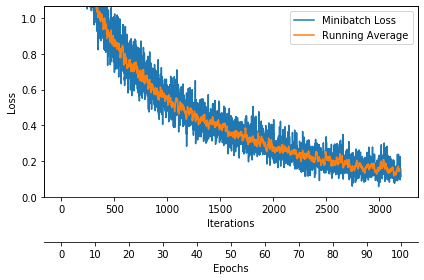

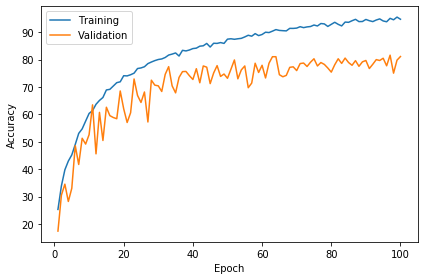

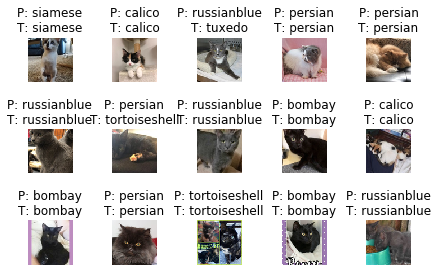

[[177   0   4   8   1   0   8   4]
 [  0 146   2   2   5   8  12  16]
 [  6  14 149   5   6   8   6   6]
 [  6   2   3 162   3   4   2   3]
 [  1  14  11   8 159   2   1   9]
 [  0  14   3   2   0 174   5   3]
 [  5  12   3   8   0   7 180   3]
 [  7   9   1   4   2   0   3 172]]


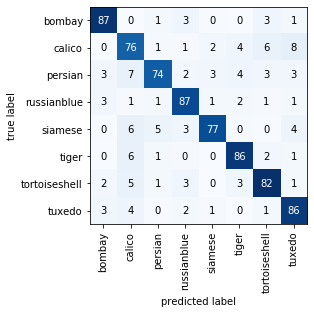

In [7]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
print(conf_matrix)
plot_confusion_matrix(conf_matrix, class_names=cat_dict.values(), test_data_distribution=test_data_distribution)
plt.show()